In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn.apionly as sns
from scipy.stats.kde import gaussian_kde
%matplotlib inline
from IPython.html import widgets
from IPython.html.widgets import interact,fixed

In [36]:
filepath = '/notebooks/moldev-data/analyzed/07-15-2015/ssC PNA.csv'
cells = pd.read_csv(filepath)

In [37]:
intensity = cells['NucIntegrated Intensity_Avg'].values

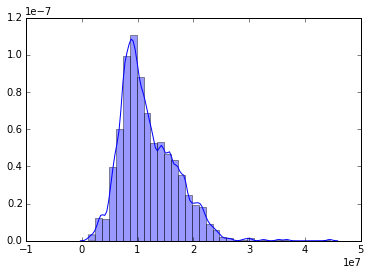

In [32]:
interact(lambda xs,bandwidth: sns.distplot(xs,kde_kws = {'bw':bandwidth,'kernel':'gau'}),
         xs = fixed(intensity),
         bandwidth = widgets.FloatSlider(min = 0,
                                         max = max(intensity)/20,
                                         step = np.mean(intensity)/50,
                                         value = np.mean(intensity)));

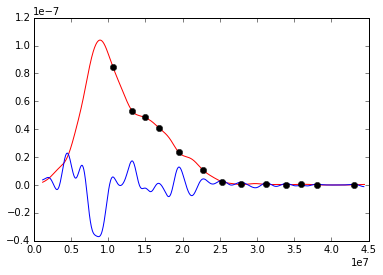

In [138]:

def f(bw):
    my_pdf = gaussian_kde(intensity,bw_method=bw)
    x = np.linspace(min(intensity),max(intensity),1000)
    p1 = np.diff(my_pdf(x))
    p2 = np.diff(p1) * 10**3
    plt.plot(x,my_pdf(x),'r') # distribution function
    plt.plot(x[:-2],p2,'b')
    
#     thresh_x,thresh_y = get_threshold(intensity,bw)
#     plt.plot(thresh_x,thresh_y,'ko')
    thresh_xs,thresh_ys = get_thresholds(intensity,bw)
    plt.plot(thresh_xs,thresh_ys,'ko')

    return my_pdf
#     plt.hist(intensity,normed=1,alpha=.3,bins=200) # histogram

interact(f,bw=widgets.FloatSlider(min=0.05,max=0.4,step=0.01,value=0.5));

In [80]:
import scipy.signal as signal
x = np.array([2, 1, 2, 3, 2, 0, 1, 0])
scipy.signal.argrelmax(x)

(array([3, 6]),)

In [112]:
def get_threshold(vals,bw):
    pdf = gaussian_kde(vals,bw_method=bw)
    x = np.linspace(min(vals),max(vals),1000)
    y = pdf(x)
    ddx = np.diff(np.diff(y))
    peak = np.argmin(ddx)
    index = min([yi for yi in signal.argrelmax(ddx)[0] if yi > peak])
    return (x[index],pdf(x[index])[0])

In [113]:
thresh = get_threshold(intensity,0.3)

In [117]:
def get_thresholds(vals,bw):
    pdf = gaussian_kde(vals,bw_method=bw)
    x = np.linspace(min(vals),max(vals),1000)
    y = pdf(x)
    ddx = np.diff(np.diff(y))
    peak = np.argmin(ddx)
    indices = [yi for yi in signal.argrelmax(ddx)[0] if yi > peak]
    return (x[indices],pdf(x[indices]))

In [118]:
get_thresholds(intensity,0.3)

(array([ 13007488.3003003 ,  19632370.53453454,  24568557.2972973 ,
         32838835.11911912,  38987418.63063063,  41672011.43143144]),
 array([  5.86221028e-08,   2.47445329e-08,   4.99255522e-09,
          3.55344169e-10,   7.79948503e-11,   3.93228964e-11]))

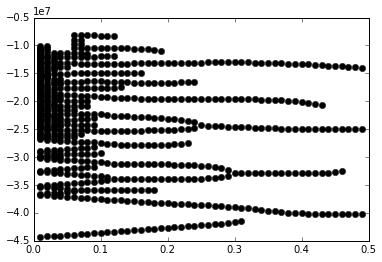

In [131]:
bws = np.arange(0.01,0.5,0.01)
results = [get_thresholds(intensity,bw)[0] for bw in bws]

for bw,result in zip(bws,results):
    plt.plot([bw]*len(result),result * -1,'ko')

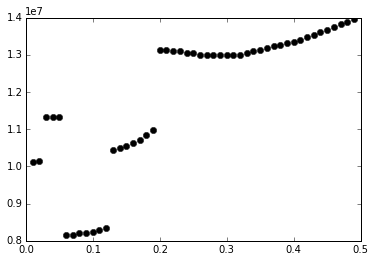

In [139]:
bws = np.arange(0.01,0.5,0.01)
results = np.array([get_threshold(intensity,bw)[0] for bw in bws])
plt.plot(bws,results,'ko')

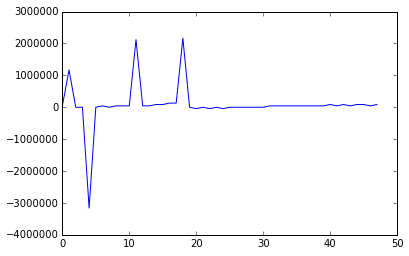

In [137]:
plt.plot(np.diff(results))

In [140]:
# [Float] -> Float
def get_threshold(intensity):
    """ Given an array of intensities, find the intensity 
        threshold separating the G1 peak from the S/G2 peak. """
    kde_fit = gaussian_kde(intensity,0.3)
    x = np.linspace(min(intensity),
                    max(intensity),
                    1000)
    y = kde_fit(x)
    ddx = np.diff(np.diff(y)) # second derivative of fit
    peak = np.argmin(ddx) # most frequent intensity 
    index = min([yi for yi in signal.argrelmax(ddx)[0] if yi > peak])
    threshold = x[index]
    return threshold